In [85]:
%pylab inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from itertools import product
import warnings

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [65]:
wag = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

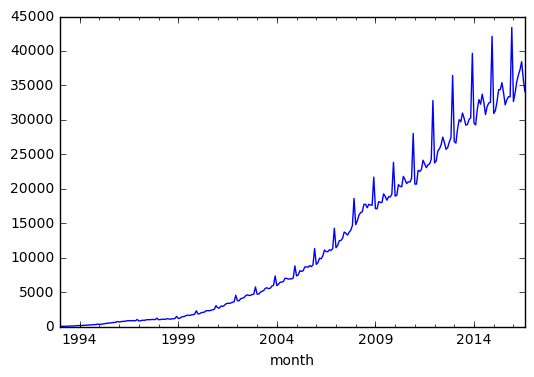

In [66]:
#1. Визуализация данных
wag.WAG_C_M.plot()

In [67]:
#2. Стабилизация дисперсии
wag["WAG_C_M_lmda"], lmbda = stats.boxcox(wag.WAG_C_M)
print lmbda

0.263201754184


In [68]:
#3. Выбор порядка дифференцирования
sm.tsa.stattools.adfuller(wag.WAG_C_M_lmda)

(-1.1447539478876003,
 0.69689876348327595,
 13L,
 270L,
 {'1%': -3.4548039258751206,
  '10%': -2.5725063100137175,
  '5%': -2.8723049286186049},
 -16.017167830688777)

In [69]:
#Избавляемся от сезонности
wag.WAG_C_M_lmda_12 = wag.WAG_C_M_lmda - wag.WAG_C_M_lmda.shift(12)
wag.WAG_C_M_lmda_12.dropna(inplace=True)
sm.tsa.stattools.adfuller(wag.WAG_C_M_lmda_12)

(-3.3040788019274525,
 0.014697133494791808,
 6L,
 265L,
 {'1%': -3.4552699038400827,
  '10%': -2.5726152830188678,
  '5%': -2.8725092359464526},
 -11.623584289767962)

(-6.221729105121919, 5.2036037158214299e-08, 11L, 259L, {'5%': -2.8727648817786648, '1%': -3.4558530692911504, '10%': -2.5727516430882069}, -4.2699959811664598)


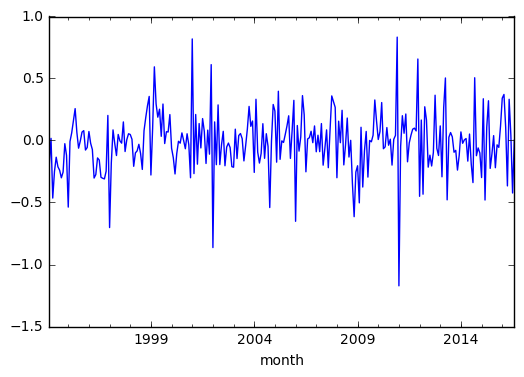

In [70]:
#При избавлении от сезонности ряд стал более стационарным, пробуем улучшить стационарность первым порядком дифференцирования
wag.WAG_C_M_lmda_12_1 = wag.WAG_C_M_lmda_12 - wag.WAG_C_M_lmda_12.shift(1)
wag.WAG_C_M_lmda_12_1.dropna(inplace=True)
print sm.tsa.stattools.adfuller(wag.WAG_C_M_lmda_12_1)

wag.WAG_C_M_lmda_12_1.plot()

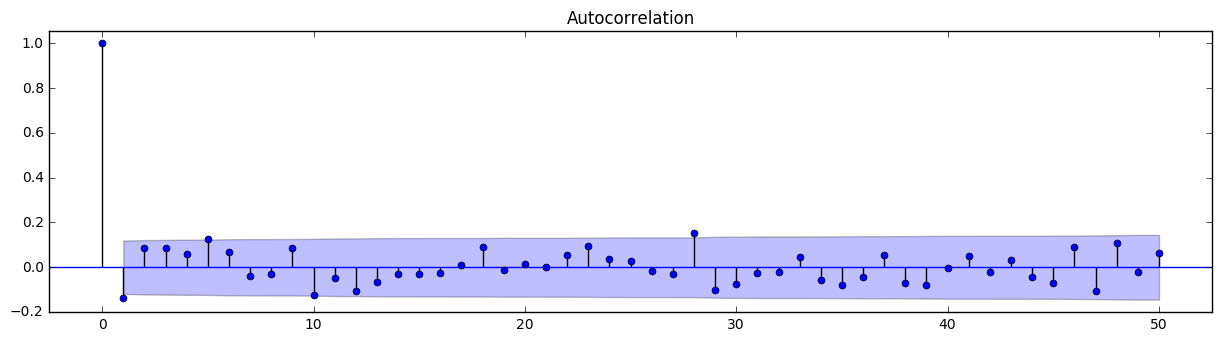

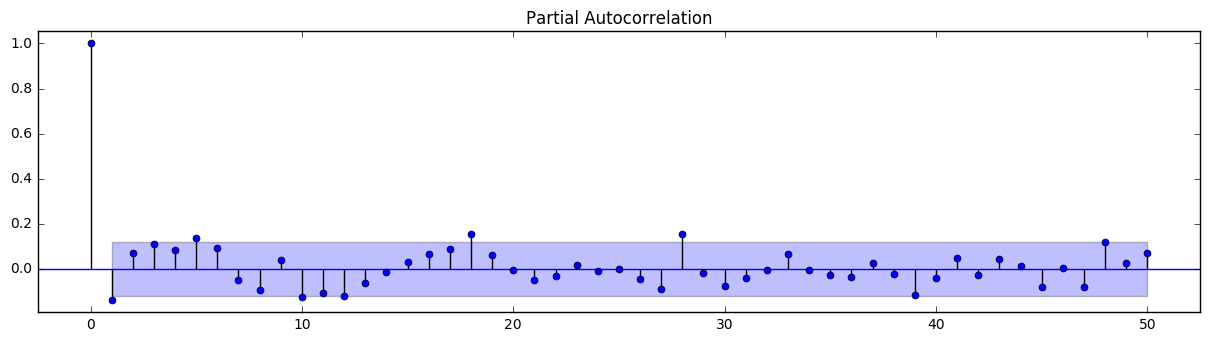

In [73]:
#4. Выбор начальных приближений для p,q,P,Q
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag.WAG_C_M_lmda_12_1.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag.WAG_C_M_lmda_12_1.squeeze(), lags=50, ax=ax)
pylab.show()

In [100]:
#Начальные приближения q=1, Q=0, p=1, P=1 
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [101]:
#5. Обучение и сравнение моделей-кандидатов, выбор победителя
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wag.WAG_C_M_lmda, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))


In [102]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
4  (1, 0, 1, 0)  0.340521
2  (0, 1, 1, 0)  1.170768
6  (1, 1, 1, 0)  2.021911
3  (1, 0, 0, 0)  2.625709
1  (0, 1, 0, 0)  3.369832


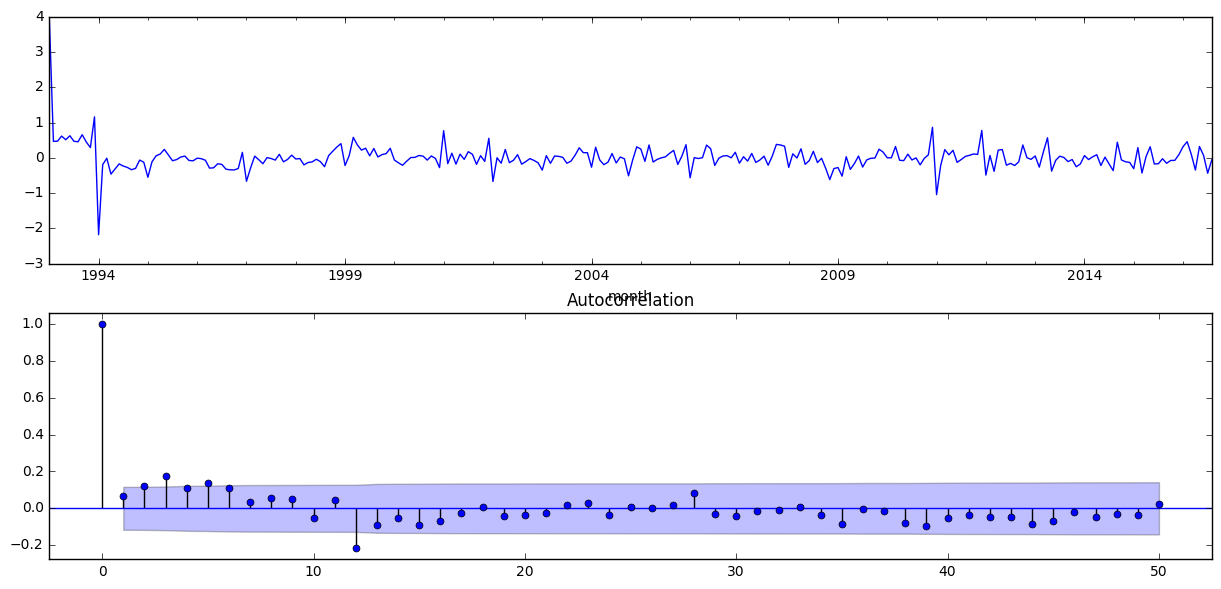

t-test, p-value:0.834017644081  - остатки несмещены
Ttest_1sampResult(statistic=0.20974496427484041, pvalue=0.83401764408106838)

Дики-Фулер, p-value:3.59965319653e-07 - остатки стационарны
(-5.8504523995678301, 3.5996531965271107e-07, 5L, 278L, {'5%': -2.8719934111688965, '1%': -3.4540935579190495, '10%': -2.5723401594120388}, -12.457744664062375)

[  2.66299656e-01   6.63362733e-02   2.75765367e-03   1.55143344e-03
   3.15971288e-04   1.76400890e-04   3.44277518e-04   5.02177545e-04
   7.48107022e-04   1.08504995e-03   1.61860404e-03   1.56187318e-05
   1.28586912e-05   1.89490024e-05   1.49772675e-05   1.71307644e-05
   2.99605244e-05   5.38282315e-05   7.95265580e-05   1.16739537e-04
   1.82101131e-04   2.90885533e-04   4.32447876e-04   6.01711825e-04
   9.24864034e-04   1.39905305e-03   2.03373544e-03   1.64493497e-03
   2.24254562e-03   2.73920725e-03   3.80580200e-03   5.27983655e-03
   7.23151126e-03   8.81051914e-03   6.63796410e-03   8.96927054e-03
   1.17101055e-02   9.95759

In [125]:
#6. Анализ остатков построенной модели
plt.subplot(211)
best_model.resid.plot()
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)
pylab.show()

#Проверка на смещенность остатков
stat = stats.ttest_1samp(best_model.resid, 0)
print "t-test, p-value:{}  - остатки несмещены".format(stat[1])
print stat
print

#проверка стационарности остатков
stat = sm.tsa.stattools.adfuller(best_model.resid)
print "Дики-Фулер, p-value:{} - остатки стационарны".format(stat[1])
print stat
print

#проверка автокоррелированности остатков по критерию Люнга-Бокса - остатки неавтокоррелированы
_, q_stat, p_val = sm.tsa.stattools.acf(best_model.resid, qstat=True) 
print p_val

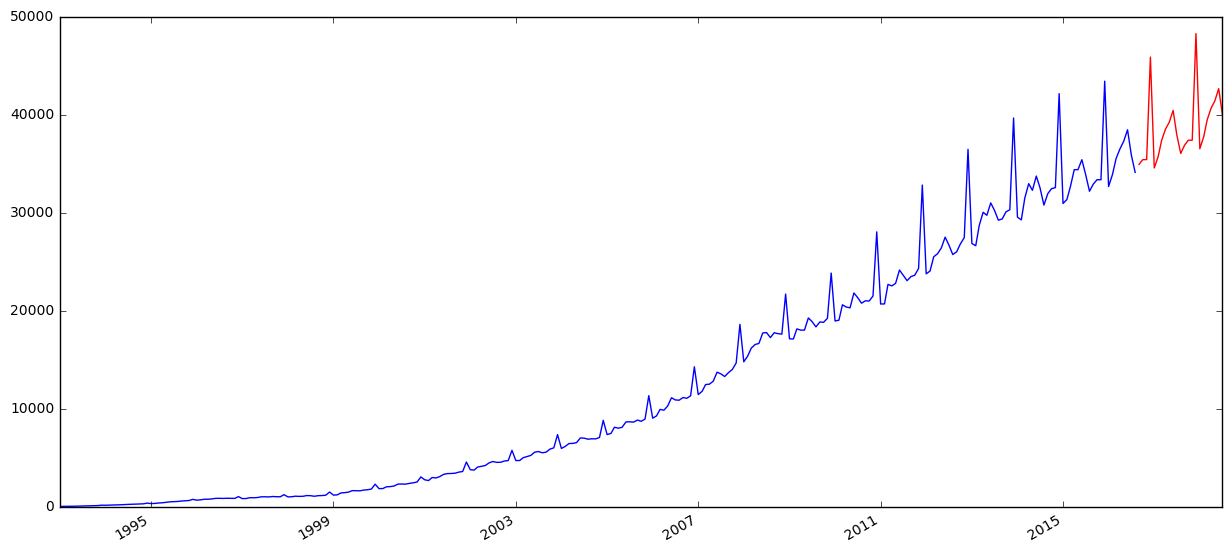

In [133]:
#6. Прогнозирование с помощью финальной модели
date_list = [wag.index.max() + relativedelta(months=x) for x in range(0, 24)]
future = pd.DataFrame(index=date_list, columns=wag.columns)
wag2 = pd.concat([wag, future])
wag2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
wag2.WAG_C_M.plot()
wag2.forecast.plot(color='r')
pylab.show()